# StackOverflow Modeling

This workbook demonstrates machine learning models for the project.  
For data pre-processing and exploritory analysis, please refer to   
https://github.com/yuqinouou/Springboard/blob/master/Capstone_Project/notebook/StackOverflow_EDA_Questions_Quality_Final.ipynb  



In [73]:
# load packages
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler, QuantileTransformer, PolynomialFeatures

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier, RidgeCV, LassoCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.metrics import roc_auc_score, f1_score, log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import median_absolute_error, r2_score, classification_report

from nltk.corpus import stopwords

In [3]:
%%time
# load dataset
file_path = "/Volumes/DockerDrive/"
df = pd.read_csv(file_path+"final_df.csv", index_col = "CreationDate", parse_dates=True)
df = df.drop('Unnamed: 0', axis=1)
df['TimeToFirstAnswer'] = pd.to_timedelta(df['TimeToFirstAnswer'])
df['TimeToFirstAcceptedAnswer'] = pd.to_timedelta(df['TimeToFirstAcceptedAnswer'])

CPU times: user 45.5 s, sys: 1.61 s, total: 47.1 s
Wall time: 46.8 s


## Model 1 - Feature Clustering

To better understand the association between text features, I performed a clustering model to cateogrize question posts with features.

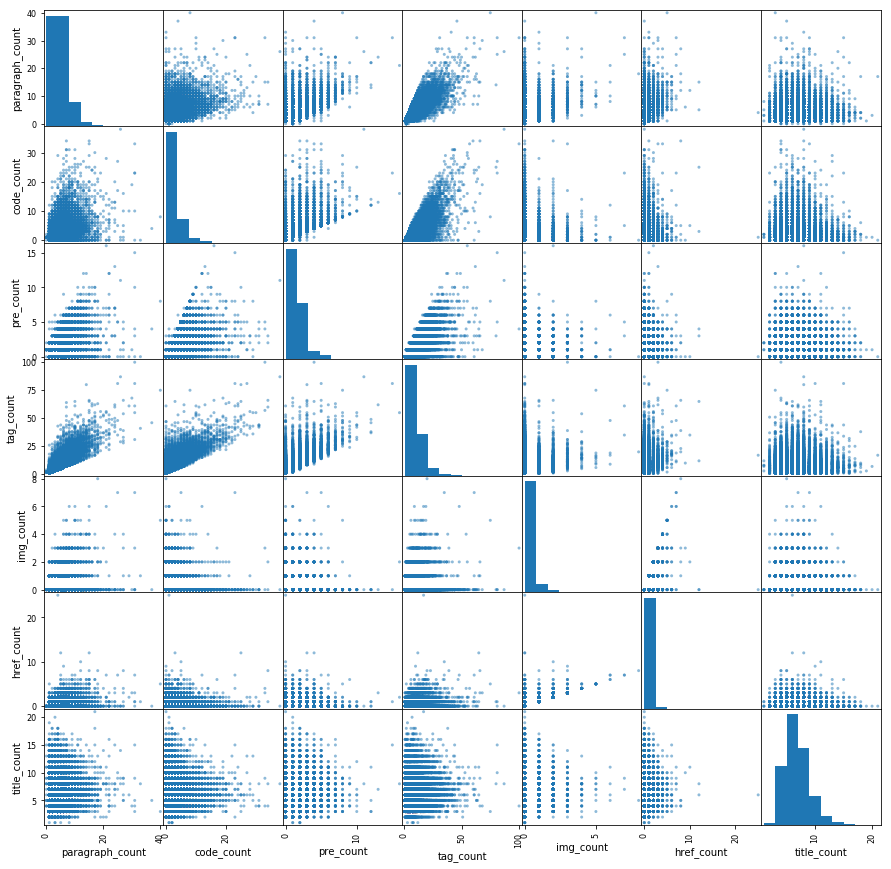

In [4]:
text_features = ['paragraph_count', 'code_count', 'pre_count', 'tag_count',
                 'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']
text_features_cts = ['paragraph_count', 'code_count', 'pre_count', 'tag_count', 
                     'img_count', 'href_count', 'title_count']
pd.plotting.scatter_matrix(df[text_features_cts].sample(frac=0.01), figsize = (15, 15))
plt.show()

In [5]:
# scaler and transform the data for KMmeans to perform well
scaler = StandardScaler()
pca = PCA()
df_ = scaler.fit_transform(df[text_features])
df_pca = pca.fit_transform(df_)
print(pca.explained_variance_ratio_)

/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[0.32790312 0.18783023 0.14036281 0.11435963 0.08062865 0.0545543
 0.0513103  0.03615991 0.00689104]


CPU times: user 17.5 ms, sys: 2.96 ms, total: 20.5 ms
Wall time: 17.8 ms


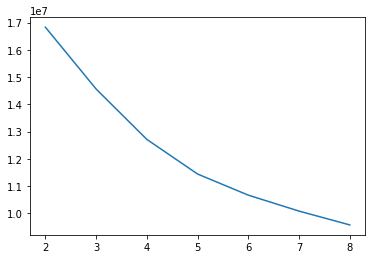

In [8]:
%%time
# try different n_clusters
model_lst = []
inertia_lst = []
for i in range(2, 9):
    model = KMeans(n_clusters=i)
    model.fit(df_pca)
    print(model.inertia_)
    model_lst.append(model)
    inertia_lst.append(model.inertia_)
plt.plot(range(2, 9), inertia_lst)

In [10]:
# pick 5 cluster model
cluster_model = model_lst[3]
# print feature mean matrix
df['label'] = cluster_model.predict(df_pca)
df_summ = df[['label'] + text_features].groupby('label').mean()
df_summ.round(2).to_csv(file_path+'/plt/cov_table.csv')
df_summ.round(2)

,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful
label,,,,,,,,,
0,3.44,1.80,1.09,6.91,0.06,0.20,5.75,0.00,0.00
1,8.48,7.10,3.47,21.49,0.06,0.34,6.47,0.27,0.31
2,7.28,2.25,1.15,12.33,1.86,2.64,6.54,0.32,0.33
3,4.17,1.59,1.08,7.49,0.07,0.22,6.31,0.31,1.00
4,3.21,1.75,0.96,6.48,0.06,0.21,7.18,1.00,0.01


In [11]:
df['label'].value_counts()

0    839588
3    565753
4    490267
1    330486
2     99203
Name: label, dtype: int64

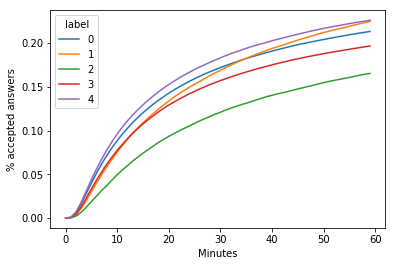

In [12]:
plot_data = pd.concat([df.groupby('label')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(0, 60)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['label', 'Minutes', 'Cumulative_Percentage']
plot_data.pivot(index='Minutes', columns='label', values='Cumulative_Percentage').plot()
plt.ylabel('% accepted answers')
plt.savefig(file_path+'/plt/cluster1.png')
plt.show()

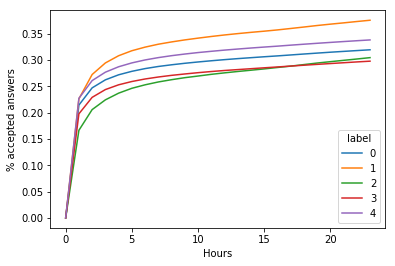

In [13]:
plot_data = pd.concat([df.groupby('label')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(hours = i))), [i])) for i in range(0, 24)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['label', 'Hours', 'Cumulative_Percentage']
plot_data.pivot(index='Hours', columns='label', values='Cumulative_Percentage').plot()
plt.ylabel('% accepted answers')
plt.savefig(file_path+'/plt/cluster2.png')
plt.show()

I chose five cluster since the magnitute for inertia declining slows down past 5 clusters. By checking mean values for each feature, we can get an idea of different styles of question posting:  

0. questions with statement title and no thankful words.  
1. wordy questions with a lot paragraphs and code chunks.  
2. wordy questions with a lot paragraphs, less code chunks but more images and external links.  
3. questions with thankful workds.  
4. questions with question title and no thankful words.  

Cluster 0 and Cluster 4 is comparible. It seems using question title will be helpful increasing the chance to get an quality answer. However both groups doing better than cluster 3.  

This implies we missed some important features that confounded the result. For example, less-experienced programmers might be less confident in their narritive to the questions, and being extremely polite. That's how we might observe the negative association between being polite and question being bad, but it's not causal, and the real cause is less-experienced users.  

Cluster 1 and 2 has the same pattern: while they might not have caught most attention within the first hour, they got more answers later on and growing even faster than other clusters. The could due to readability of those long posts. The difference is that cluster 1 got much more questions answered than cluster 2, meaning that plots and links are not as helpful as having more code chunks.  

## Model 2 - Classification Model

In this section, I tried to fit a classification model to predict if a question will get answered within a day. The idea is that if we can identify question posts that are not likely to get answered, we might be able to do something to inform the user to edit further.

In [15]:
# get outcome class, <=1day, >1day
t = df['TimeToFirstAcceptedAnswer'].copy()
t[t.isna()] = timedelta(days=999)
t=t/timedelta(minutes=1)
y = np.array(t<=60*24)

In [16]:
# %positive is 33%, this is unbalanced.
np.mean(y)

0.32683996925984077

In [17]:
# construct feature matrix
# get time features
df['is_weekday'] = df.index.weekday.isin([0,1,2,3,4])
# get tags features
df.Tag_Doc[df.Tag_Doc.isna()] = ['NA']*5
cv = CountVectorizer(min_df=1000, max_features=30, token_pattern='\S+')
counts = cv.fit_transform(df.Tag_Doc)
df_posttag = pd.DataFrame(pd.SparseDataFrame(counts))
words = np.array(cv.get_feature_names()) 
df_posttag.columns = words
df_posttag = df_posttag.fillna(0)
tags_features = df_posttag.columns.values
other_feature = ['is_weekday']

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
tags_features = df_posttag.columns.values

In [34]:
# first, x with all original features
x = pd.concat([df[text_features + other_feature].reset_index(drop=True), 
               df_posttag[tags_features].reset_index(drop=True)], axis=1)

In [39]:
# second, x_log with all count data log1p transformed
x_log = x.copy()
x_log[text_features_cts] = np.log1p(x_log[text_features_cts])

In [43]:
%%time
# third, x_int with order 3 interactions between none-tag features
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
x_int = pd.concat([pd.DataFrame(interaction.fit_transform(x[text_features + other_feature])),
                  df_posttag[tags_features].reset_index(drop=True)], axis=1)

CPU times: user 56.1 s, sys: 22 s, total: 1min 18s
Wall time: 45.5 s


In [66]:
# testing function
dict_classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Decision Tree": tree.DecisionTreeClassifier(max_depth = 6, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    #"Nearest Neighbors": KNeighborsClassifier(),
    #"Linear SVM": SVC(),
    #"Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=20),
    #"Random Forest": RandomForestClassifier(n_estimators = 500, max_depth = 10, n_jobs=-1),
    #"Neural Net": MLPClassifier(alpha = 1),
    #"AdaBoost": AdaBoostClassifier(),
    #"QDA": QuadraticDiscriminantAnalysis(),
    #"Gaussian Process": GaussianProcessClassifier()
}

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        
        #train_score = classifier.score(X_train, Y_train)
        #test_score = classifier.score(X_test, Y_test)
        #train_score = roc_auc_score(Y_train, classifier.predict_proba(X_train)[:,1])
        #test_score = roc_auc_score(Y_test, classifier.predict_proba(X_test)[:,1])
        #train_score = log_loss(Y_train, classifier.predict_proba(X_train)[:,1])
        #test_score = log_loss(Y_test, classifier.predict_proba(X_test)[:,1])
        train_score = f1_score(Y_train, classifier.predict(X_train), average='weighted')
        test_score = f1_score(Y_test, classifier.predict(X_test), average='weighted')
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models

def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

In [45]:
# train test split
ind_train, ind_test = train_test_split(range(len(y)), test_size = 0.30, random_state = 123)

In [67]:
import warnings
warnings.filterwarnings('ignore')

dict_models = batch_classify(x.iloc[ind_train], y[ind_train], x.iloc[ind_test], y[ind_test], no_classifiers = 3)
display_dict_models(dict_models)
#import pickle
#filename = file_path+'/model/models.sav'
#pickle.dump(dict_models, open(filename, 'wb'))

trained Logistic Regression in 20.25 s
trained Decision Tree in 22.65 s
trained Naive Bayes in 9.81 s


,classifier,train_score,test_score,train_time
2,Naive Bayes,0.613748,0.613571,9.812715
0,Logistic Regression,0.605126,0.605673,20.246483
1,Decision Tree,0.579149,0.578892,22.651645


In [71]:
dict_models = batch_classify(x_log.iloc[ind_train], y[ind_train], x_log.iloc[ind_test], y[ind_test], no_classifiers = 3)
display_dict_models(dict_models)

trained Logistic Regression in 16.66 s
trained Decision Tree in 22.99 s
trained Naive Bayes in 10.20 s


,classifier,train_score,test_score,train_time
2,Naive Bayes,0.614731,0.614347,10.198848
0,Logistic Regression,0.598500,0.599080,16.661808
1,Decision Tree,0.579149,0.578892,22.993338


In [77]:
dict_models = batch_classify(x_int.iloc[ind_train], y[ind_train], x_int.iloc[ind_test], y[ind_test], no_classifiers = 3)
display_dict_models(dict_models)

trained Logistic Regression in 434.73 s
trained Decision Tree in 162.33 s
trained Naive Bayes in 56.73 s


,classifier,train_score,test_score,train_time
1,Decision Tree,0.589488,0.588862,162.329550
2,Naive Bayes,0.588208,0.588847,56.730022
0,Logistic Regression,0.573555,0.573728,434.730363


In [81]:
print(confusion_matrix(y[ind_test], dict_models['Logistic Regression']['model'].predict(x_int.iloc[ind_test])))  

[[271033 198748]
 [ 97095 130714]]


In [82]:
print(classification_report(y[ind_test], dict_models['Logistic Regression']['model'].predict(x_int.iloc[ind_test])))  

              precision    recall  f1-score   support

       False       0.74      0.58      0.65    469781
        True       0.40      0.57      0.47    227809

   micro avg       0.58      0.58      0.58    697590
   macro avg       0.57      0.58      0.56    697590
weighted avg       0.63      0.58      0.59    697590



None of the three models really out-perform the other two. We pick logistic regression with orignal non-transformed dataset and try to tune the training parameters. SGD with log-loss gives us a logistic regression estimator.

In [97]:
param_grid = {'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.7, 1],
              'alpha': [0.0001, 0.001, 0.01, 0.1, 1] }
enet = SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight='balanced')
cv = GridSearchCV(enet, param_grid=param_grid, scoring='f1_weighted', n_jobs=6, cv=5, verbose=1)
cv = cv.fit(x.iloc[ind_train], y[ind_train])

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 175 out of 175 | elapsed: 41.7min finished


In [98]:
pd.DataFrame(cv.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
13,"{'alpha': 0.001, 'l1_ratio': 1}",0.617318,1
1,"{'alpha': 0.0001, 'l1_ratio': 0.05}",0.610296,2
15,"{'alpha': 0.01, 'l1_ratio': 0.05}",0.602448,3
25,"{'alpha': 0.1, 'l1_ratio': 0.5}",0.602150,4
17,"{'alpha': 0.01, 'l1_ratio': 0.2}",0.601366,5
26,"{'alpha': 0.1, 'l1_ratio': 0.7}",0.601363,6
14,"{'alpha': 0.01, 'l1_ratio': 0}",0.601241,7
8,"{'alpha': 0.001, 'l1_ratio': 0.05}",0.599852,8
18,"{'alpha': 0.01, 'l1_ratio': 0.5}",0.597855,9
16,"{'alpha': 0.01, 'l1_ratio': 0.1}",0.595999,10


with l1_ratio = 1 and alpha = 1e-3, our best model yields a weighted average f1 of 0.617. This is considered a mediocre model with not much prediction power. We can check other score measures on both training and testing sets.

In [99]:
print(log_loss(y[ind_train], cv.predict_proba(x.iloc[ind_train])[:,1]))
print(log_loss(y[ind_test], cv.predict_proba(x.iloc[ind_test])[:,1]))
print(roc_auc_score(y[ind_train], cv.predict_proba(x.iloc[ind_train])[:,1]))
print(roc_auc_score(y[ind_test], cv.predict_proba(x.iloc[ind_test])[:,1]))
print(accuracy_score(y[ind_train], cv.predict(x.iloc[ind_train])))
print(accuracy_score(y[ind_test], cv.predict(x.iloc[ind_test])))    
print(confusion_matrix(y[ind_test], cv.predict(x.iloc[ind_test]))) 
print(classification_report(y[ind_test], cv.predict(x.iloc[ind_test]))) 

0.6560767758132425
0.6558942013095278
0.6101413783693279
0.6104008751175576
0.6293767858711672
0.6299430897805302
[[348894 120887]
 [137261  90548]]
              precision    recall  f1-score   support

       False       0.72      0.74      0.73    469781
        True       0.43      0.40      0.41    227809

   micro avg       0.63      0.63      0.63    697590
   macro avg       0.57      0.57      0.57    697590
weighted avg       0.62      0.63      0.63    697590



The coefficient table below can give us an idea of the contribution of each feature to the model.

In [100]:
coef_df = pd.DataFrame(cv.best_estimator_.coef_)
coef_df.columns = x.columns
coef_df = coef_df.transpose()
coef_df.columns = ['Coefficient']

In [101]:
coef_df

,Coefficient
paragraph_count,-0.030249
code_count,0.072176
pre_count,0.126681
tag_count,-0.011717
img_count,0.060694
href_count,-0.029895
title_count,-0.055304
is_question,0.126998
is_thankful,-0.066927
is_weekday,0.000000


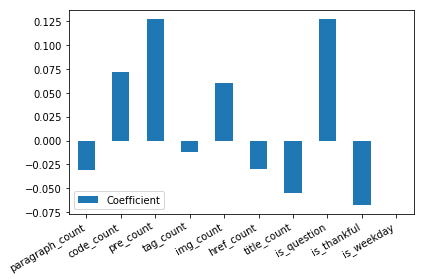

In [126]:
coef_df.loc[text_features + other_feature].plot(kind='bar')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(file_path+'/plt/coef1.png')

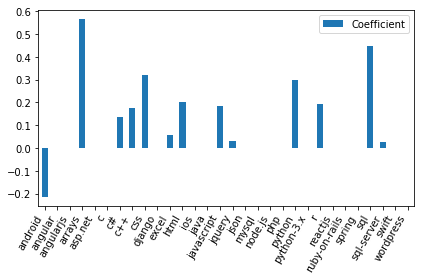

In [127]:
coef_df.loc[tags_features].plot(kind='bar')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig(file_path+'/plt/coef2.png',)

For the derived features from text, we can see it's good to have more code chunks, pre-formatting and imagies, and it's not suggeted to have too many paragraphs or too many external links. It is good to state you question as an actual question, not in a statement. It doesn't matter that much when it was posted. 

The coefficient by tags are actually varying quite much. So questions in different topic area definitely have different levels of popularity.

Next, we can demonstrate some sample questions with high and low prediction probabilities.

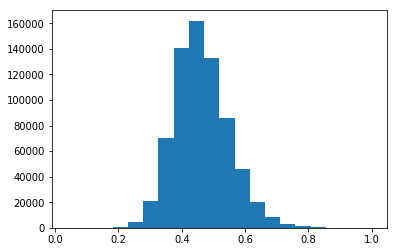

In [102]:
prob_test = cv.predict_proba(x.iloc[ind_test])
prob_test_array = np.copy(prob_test[:,1])
plt.hist(prob_test_array, bins=20)
plt.show()

In [103]:
prob_test_array.sort()
print(prob_test_array[-11:-1])
print(prob_test_array[0:10])

[0.98575962 0.98623752 0.99176949 0.99196076 0.99218747 0.99368106
 0.99377557 0.99519827 0.99829249 0.99933758]
[0.03775376 0.04295651 0.04409235 0.04453349 0.04561104 0.04562302
 0.05322293 0.0534705  0.05496581 0.05516235]


In [104]:
inds = x.iloc[ind_test].index[prob_test[:,1].argsort()]

In [105]:
df.iloc[inds[-11:-1]]

,Id,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful,Tag_Doc,AcceptedAnswerId,TimeToFirstAnswer,TimeToFirstAcceptedAnswer,label,is_weekday
CreationDate,,,,,,,,,,,,,,,,
2017-03-20 12:37:42.720,42903817,3,80,0,84,0,0,10,True,False,list prestashop combinations backend product,0,NaT,NaT,1,True
2017-06-07 15:49:26.163,44417399,13,68,6,95,0,0,7,True,True,sql sql-server sql-server-2008 tsql stored-pro...,0,NaT,NaT,1,True
2017-07-06 07:53:46.840,44942901,17,74,11,100,0,0,4,False,False,java jar,0,0 days 00:42:11.277000,NaT,1,True
2017-06-23 04:18:49.650,44712989,3,84,1,89,0,0,6,True,False,django,0,0 days 00:08:59.933000,NaT,1,True
2017-11-23 06:22:16.233,47448863,24,81,11,100,1,1,10,True,True,apache-spark hdfs monitoring ganglia gmetad,0,NaT,NaT,1,True
2017-03-31 03:39:53.280,43132025,26,82,12,100,0,2,7,True,True,c callback gtk gio,43222520,5 days 01:48:14.680000,5 days 01:48:14.680000,1,True
2017-03-19 20:07:48.063,42891633,14,93,1,100,1,1,3,False,False,php laravel,0,0 days 00:04:54.297000,NaT,1,False
2017-04-08 05:18:12.823,43290467,50,59,32,100,0,2,8,True,True,javascript algorithm math language-agnostic pe...,0,0 days 02:58:42.584000,NaT,1,False
2017-08-08 10:38:45.250,45566096,50,92,22,100,0,2,5,False,False,ldap kerberos openldap gentoo gssapi,45575700,0 days 07:56:26.593000,0 days 07:56:26.593000,1,True


In [106]:
df.iloc[inds[0:10]]

,Id,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful,Tag_Doc,AcceptedAnswerId,TimeToFirstAnswer,TimeToFirstAcceptedAnswer,label,is_weekday
CreationDate,,,,,,,,,,,,,,,,
2017-08-03 12:41:47.467,45484523,50,0,0,88,0,0,13,True,True,java birt,0,NaT,NaT,1,True
2017-04-13 12:32:01.440,43392422,50,0,0,94,0,0,7,False,True,servlets weblogic oracle-adf jdeveloper java-6,43392689,0 days 00:12:13.313000,0 days 00:12:13.313000,1,True
2017-05-20 09:14:30.940,44084050,50,1,0,100,0,1,6,False,True,node.js angular angular-upgrade,44084180,0 days 00:13:48.150000,0 days 00:13:48.150000,1,False
2017-02-03 04:32:57.997,42016832,50,0,0,88,0,0,12,False,False,c++ .net windows,0,NaT,NaT,1,True
2017-02-04 10:09:22.363,42039071,50,0,0,95,0,0,9,True,True,excel vba excel-vba optimization subset,0,NaT,NaT,1,False
2017-01-31 11:52:25.683,41956887,50,0,0,100,0,0,9,False,False,c++ visual-c++ mfc,0,2 days 00:29:42.284000,NaT,1,True
2017-11-01 13:49:11.670,47056434,50,1,1,79,0,0,12,True,True,java web-services liferay-7 sakai linkageerror,0,NaT,NaT,1,True
2017-02-06 15:34:03.840,42071515,50,2,2,100,2,2,6,False,True,java android go react-native gomobile,42104990,1 days 13:18:47.517000,1 days 13:18:47.517000,1,True
2017-10-31 13:53:31.167,47037139,50,0,0,94,1,3,3,False,False,http client hdfs streamsets,0,1 days 01:11:18.643000,NaT,1,True


The model seems doing okay when predicting negatives. But when predicting positives it generates a lot errors.